In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

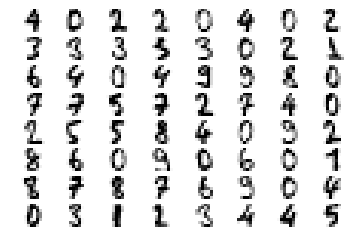

In [2]:
from random import randint

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(digits.images[randint(0, digits.images.shape[0])], cmap='Greys')
plt.show()

In [3]:
X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[:1617]
y = digits.target[:1617]

In [4]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [5]:
def get_winner(class1):
    
    numbers = [*range(10)] # number 2 > number 1
    number_of_classification = len(numbers)
    #number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

        
    class2 = []

    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = 1617
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    x_outputs1 = []
    for i in range(len(x_outputs)):
        if (x_outputs[i][0] == 1):
            x_outputs1.append(tuple([0,1]))
        else:# [i][0] == 0
            x_outputs1.append(tuple([1,0]))
    x_outputs = x_outputs1 
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            real_outputs = np.array(x_outputs).reshape(samplesize,2)
            #print(real_outputs)
            ce = -np.mean(np.sum(np.array(real_outputs) * np.log(px_outputs), axis = 1))
    

            genome.fitness = 1-ce

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 1)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist2")
    [stats, winner] = run(config_path)
    
    return winner

In [6]:
#class1 = [0, 2, 4, 6, 8]
#winner1 = get_winner(class1)

In [7]:
winner_list = []
classes = [[0,2,4,6,8],[0,4,5,8,9],[1,3,4,6,9],[1,2,3,6,7,8,9],[1,4,5,6,7],[1,3,5,7,8],[0,3,4,7,8],[1,2,3,4,5],[0,2,5,7,9],[1,2,5,6,8],[1,2,4,7,9],[0,6,7],[0,2,3],[1,8,9],[0,2,3,4,5,6,7,8,9]]

for class1 in classes:
    winner = get_winner(class1)
    winner_list.append(winner)

number of class1:803
number of class2:814

 ****** Running generation 0 ****** 

Population's average fitness: 0.10990 stdev: 0.14627
Best fitness: 0.40402 - size: (2, 13) - species 4 - id 153
Average adjusted fitness: 0.358
Mean genetic distance 2.946, standard deviation 0.482
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 5.454 sec
number of class1:806
number of class2:811

 ****** Running generation 0 ****** 

Population's average fitness: 0.09852 stdev: 0.14645
Best fitness: 0.37355 - size: (2, 13) - species 5 - id 58
Average adjusted fitness: 0.312
Mean genetic distance 2.905, standard deviation 0.454
Population of 199 members in 24 species
Total extinctions: 0
Generation time: 5.333 sec
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.09321 stdev: 0.14398
Best fitness: 0.37496 - size: (2, 13) - species 2 - id 32
Average adjusted fitness: 0.291
Mean genetic distance 2.904, standard devia

In [8]:
local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

In [9]:
winner_net0 = neat.nn.FeedForwardNetwork.create(winner_list[0], config)

In [10]:
def get_pred_real(i):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[1617:]
    test_y = digits.target[1617:]

    list_y = test_y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("class1:{}/{}:class2".format(len(class1_label),len(class2_label)))

    testsamplesize = 180
    test_x_inputs =[tuple(c) for c in test_X[class1_indexes].tolist()] + [tuple(c) for c in test_X[class2_indexes].tolist()]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    acc = np.sum(pred_outputs == real_outputs)/testsamplesize
    print("Accuracy: {}".format(acc))
    
    return[pred_outputs, real_outputs]

In [11]:
pred = []
real = []
for i in range(15):
    [pred_outputs, real_outputs] = get_pred_real(i)
    pred.append(pred_outputs)
    real.append(real_outputs)

class1:88/92:class2
Accuracy: 0.8055555555555556
class1:89/91:class2
Accuracy: 0.75
class1:93/87:class2
Accuracy: 0.5777777777777777
class1:126/54:class2
Accuracy: 0.6611111111111111
class1:94/86:class2
Accuracy: 0.7388888888888889
class1:91/89:class2
Accuracy: 0.8222222222222222
class1:90/90:class2
Accuracy: 0.5388888888888889
class1:92/88:class2
Accuracy: 0.6388888888888888
class1:88/92:class2
Accuracy: 0.6388888888888888
class1:89/91:class2
Accuracy: 0.7666666666666667
class1:93/87:class2
Accuracy: 0.55
class1:53/127:class2
Accuracy: 0.7222222222222222
class1:51/129:class2
Accuracy: 0.7166666666666667
class1:54/126:class2
Accuracy: 0.6888888888888889
class1:161/19:class2
Accuracy: 0.9055555555555556


In [12]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

In [13]:
number_codes = [[1,1,0,0,0,0,1,0,1,0,0,1,1,0,1],
[0,0,1,1,1,1,0,1,0,1,1,0,0,1,0],
[1,0,0,1,0,0,0,1,1,1,1,0,1,0,1],
[0,0,1,1,0,1,1,1,0,0,0,0,1,0,1],
[1,1,1,0,1,0,1,1,0,0,1,0,0,0,1],
[0,1,0,0,1,1,0,1,1,1,0,0,0,0,1],
[1,0,1,1,1,0,0,0,0,1,0,1,0,0,1],
[0,0,0,1,1,1,1,0,1,0,1,1,0,0,1],
[1,1,0,1,0,1,1,0,0,1,0,0,0,1,1],
[0,1,1,1,0,0,0,0,1,0,1,0,0,1,1]]

In [14]:
pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(15):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(15 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

In [15]:
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        list_P.append(i[0][1])

In [16]:
np.sum(list_P == digits.target[1617:])/180

0.40555555555555556

In [17]:
digits.target[1617:]

array([5, 2, 8, 0, 1, 7, 6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4,
       3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 2, 5, 7, 9, 5, 4,
       4, 9, 0, 8, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9,
       8, 9, 8, 4, 1, 7, 7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3,
       3, 7, 3, 3, 4, 6, 6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7,
       6, 3, 2, 1, 7, 4, 6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3,
       6, 9, 6, 1, 7, 5, 4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9,
       0, 8, 9, 8])

In [18]:
# list_P = []
# for i in pred_value:
#     print(i[0])

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, digits.target[1617:])
print(cm)

[[ 1  0  0  0  0  0  1  0  0  0]
 [ 0  6  0  0  0  6  1  2  0  0]
 [ 0  4 13  1  0  0  0  1  2  1]
 [ 0  0  1  3  0  0  0  3  0  0]
 [ 0  1  0  0  9  0  9  1  0  0]
 [ 0  1  0  4  0  2  0  1  0  1]
 [ 3  0  0  3  6  3  6  1  5  0]
 [ 0  0  1  0  0  0  0  9  0  0]
 [ 5  7  1  7  0  2  1  0 10  2]
 [ 7  0  1  0  5  5  0  1  0 14]]


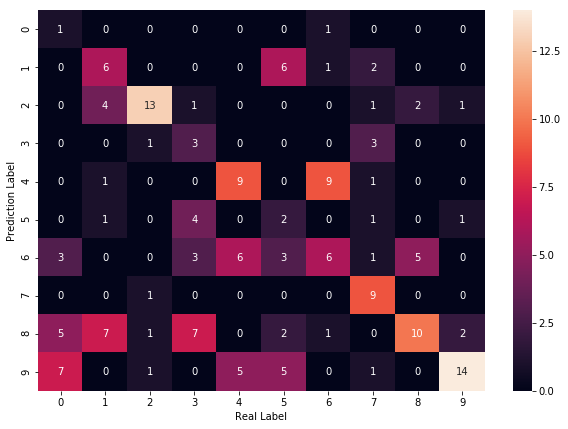

In [20]:
import seaborn as sn


df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [21]:
plt.hist(list_P)

(array([ 2., 15., 22.,  7., 20.,  9., 27., 10., 35., 33.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

In [22]:
plt.hist(digits.target[1617:])

(array([16., 19., 17., 18., 20., 18., 18., 19., 17., 18.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

In [23]:
list_P = []
for i,p_value in enumerate(pred_value):
    print("#{} min_error:{} index:{} real:{}".format(i, error_list[i], p_value[0], digits.target[1617+i]))


#0 min_error:4 index:[5 6] real:5
#1 min_error:4 index:[1 2] real:2
#2 min_error:3 index:[2] real:8
#3 min_error:4 index:[6] real:0
#4 min_error:4 index:[1 2] real:1
#5 min_error:4 index:[7] real:7
#6 min_error:2 index:[6] real:6
#7 min_error:4 index:[3 5] real:3
#8 min_error:3 index:[2] real:2
#9 min_error:2 index:[1] real:1
#10 min_error:5 index:[1 2 4 7] real:7
#11 min_error:5 index:[9] real:4
#12 min_error:3 index:[1] real:6
#13 min_error:4 index:[1 2] real:3
#14 min_error:2 index:[1] real:1
#15 min_error:4 index:[3 5] real:3
#16 min_error:4 index:[8] real:9
#17 min_error:2 index:[1] real:1
#18 min_error:4 index:[6] real:7
#19 min_error:2 index:[6] real:6
#20 min_error:3 index:[8] real:8
#21 min_error:3 index:[4] real:4
#22 min_error:4 index:[3 5] real:3
#23 min_error:2 index:[1] real:1
#24 min_error:3 index:[6] real:4
#25 min_error:4 index:[9] real:0
#26 min_error:5 index:[2 8] real:5
#27 min_error:4 index:[3 5] real:3
#28 min_error:3 index:[6] real:6
#29 min_error:3 index:[9] rea

### part 2. add more classifier

real1 ->4

In [24]:
winner_list_append = []
classes = [[1,3,8,9],[0,1,3,5,7],[0,1,5,6,7],[0,4,7,9],[1,2,6,7,8]]

for class1 in classes:
    winner = get_winner(class1)
    winner_list_append.append(winner)

number of class1:647
number of class2:970

 ****** Running generation 0 ****** 

Population's average fitness: 0.11344 stdev: 0.16849
Best fitness: 0.44995 - size: (2, 13) - species 3 - id 75
Average adjusted fitness: 0.461
Mean genetic distance 2.899, standard deviation 0.456
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 5.678 sec
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.09404 stdev: 0.14128
Best fitness: 0.37220 - size: (2, 13) - species 1 - id 32
Average adjusted fitness: 0.244
Mean genetic distance 2.974, standard deviation 0.508
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 5.311 sec
number of class1:812
number of class2:805

 ****** Running generation 0 ****** 

Population's average fitness: 0.09124 stdev: 0.13045
Best fitness: 0.35301 - size: (2, 13) - species 1 - id 139
Average adjusted fitness: 0.247
Mean genetic distance 2.869, standard devia

In [25]:
appended_winner_list = winner_list + winner_list_append

In [26]:
appended_number_codes = [[1,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,1,1,0],
[0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,1,1,1,0,1],
[1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1],
[0,0,1,1,0,1,1,1,0,0,0,0,1,0,1,1,1,0,0,0],
[1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0],
[0,1,0,0,1,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0],
[1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1],
[0,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,1,1,1,1],
[1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,0,0,1],
[0,1,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0]]

In [27]:
classes = [[0,2,4,6,8],[0,4,5,8,9],[1,3,4,6,9],[1,2,3,6,7,8,9],[1,4,5,6,7],[1,3,5,7,8],[0,3,4,7,8],[1,2,3,4,5],[0,2,5,7,9],[1,2,5,6,8],[1,2,4,7,9],[0,6,7],[0,2,3],[1,8,9],[0,2,3,4,5,6,7,8,9]] + classes



In [28]:
def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(appended_winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

In [29]:
pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(20):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)
    
    error = []
    for i in range(10):
        error.append(20 - np.sum(appended_number_codes[i] == np.array(pred).T))
    #print(error)
    
    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

In [30]:
list_P = []
for i,p_value in enumerate(pred_value):
    print("#{} min_error:{} index:{} real:{}".format(i, error_list[i], p_value[0], digits.target[1617+i]))

#0 min_error:5 index:[5 6] real:5
#1 min_error:5 index:[2] real:2
#2 min_error:5 index:[2] real:8
#3 min_error:6 index:[4] real:0
#4 min_error:6 index:[2] real:1
#5 min_error:7 index:[7] real:7
#6 min_error:4 index:[6] real:6
#7 min_error:5 index:[3] real:3
#8 min_error:5 index:[2] real:2
#9 min_error:5 index:[1] real:1
#10 min_error:7 index:[2 4 5 6] real:7
#11 min_error:7 index:[2 9] real:4
#12 min_error:5 index:[6] real:6
#13 min_error:6 index:[2 3] real:3
#14 min_error:5 index:[1] real:1
#15 min_error:5 index:[3] real:3
#16 min_error:5 index:[8] real:9
#17 min_error:6 index:[1] real:1
#18 min_error:6 index:[9] real:7
#19 min_error:3 index:[6] real:6
#20 min_error:4 index:[8] real:8
#21 min_error:4 index:[4] real:4
#22 min_error:5 index:[3] real:3
#23 min_error:6 index:[1] real:1
#24 min_error:5 index:[4 6] real:4
#25 min_error:7 index:[2 4 9] real:0
#26 min_error:7 index:[8] real:5
#27 min_error:5 index:[3] real:3
#28 min_error:4 index:[6] real:6
#29 min_error:4 index:[9] real:9
#3

In [31]:
list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])
        
np.sum(list_P == digits.target[1617:])/180

0.5

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_P, digits.target[1617:])
print(cm)

[[ 7  0  0  0  0  0  1  0  0  0]
 [ 0  5  0  0  0  0  0  1  0  0]
 [ 1  7 13  1  1  0  1  5  2  1]
 [ 0  0  1  8  0  0  0  2  0  0]
 [ 4  1  0  0 12  4  5  2  0  0]
 [ 0  1  1  2  1  7  2  1  0  1]
 [ 1  2  1  1  2  3  9  1  2  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  3  0  6  0  1  0  0 13  2]
 [ 3  0  1  0  4  3  0  5  0 14]]


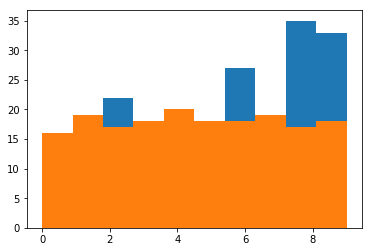

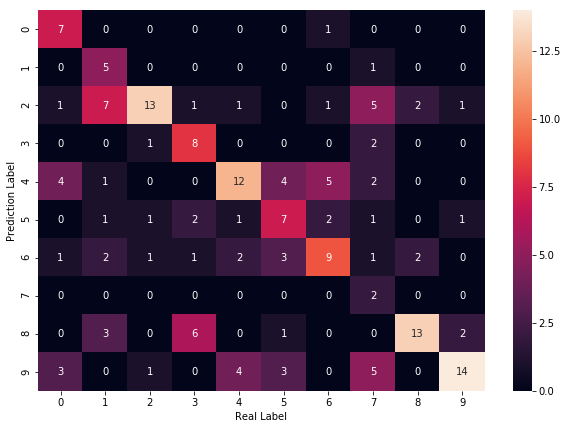

In [33]:
import seaborn as sn


df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()

In [34]:
## 加一个confusion matrix 将容易出错的两个数字增加分类！！！！比如 8 和6 容易分错，设计一个code 将8 和6 分成两类

In [35]:
## 分别绘制15个分类器的准确率随着训练的变化，有可能ecoc 的还比他们都高哈哈哈